# Étape 3 – Modélisation

## 02 - Modèles Baseline pour la Classification de Radiographies COVID-19

**Objectif**: Dans cette étape, nous préparons le dataset pour le machine learning classique en:
- Encodant les labels
- Normalisant et redimensionnant les images
- Transformant les images en vecteurs exploitables par les modèles
- Séparant le dataset en ensembles d'entraînement et de test

Nous entraînons ensuite plusieurs modèles baseline (Logistic Regression, Random Forest, SVM, KNN) pour établir une référence de performance, puis nous optimisons le meilleur.

In [11]:
# =============================================
# IMPORTS
# =============================================

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    f1_score
)

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline

print("Imports OK")

# =============================================
# COMMENTAIRE : Bibliothèques utilisées
# =============================================
# - NumPy & Pandas : manipulation des données et matrices
# - Matplotlib & Seaborn : visualisation des résultats
# - OpenCV (cv2) : traitement et redimensionnement des images
# - Scikit-learn : modèles ML (LogisticRegression, RandomForest, SVM, KNN)
# Ces imports permettent de comparer plusieurs algorithmes de ML classique.

Imports OK


## STEP 1 – Préparation des données

⚠️ **Prérequis**: Ce notebook nécessite que vous ayez exécuté le notebook `01-projet.ipynb` et que les variables `X_list` et `df_images` soient disponibles.

Si ce n'est pas le cas, exécutez la cellule suivante pour charger les données.

In [12]:
# =============================================
# CHARGEMENT DES DONNÉES (si nécessaire)
# =============================================

try:
    X_list
    df_images
    print("✅ Données déjà chargées")
except NameError:
    print("⏳ Chargement des données depuis le disque...")
    
    DATA_DIR = "../data/COVID-19_Radiography_Dataset"
    classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    
    X_list = []
    labels = []
    
    for class_name in classes:
        class_dir = os.path.join(DATA_DIR, class_name, 'images')
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith('.png'):
                    img_path = os.path.join(class_dir, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        X_list.append(img)
                        labels.append(class_name)
    
    df_images = pd.DataFrame({'label': labels})
    print(f"✅ Chargé {len(X_list)} images")

# =============================================
# COMMENTAIRE : Chargement des données
# =============================================
# On charge les images en niveaux de gris depuis les 4 classes.
# Résultat attendu : ~21 165 images au total.

✅ Données déjà chargées


In [13]:
# =============================================
# PRÉPARATION DES DONNÉES POUR ML CLASSIQUE
# =============================================

print("=== 1️⃣ Redimensionnement des images à 64x64 ===")
# On utilise des images plus petites pour accélérer l'entraînement
TARGET_SIZE = (64, 64)
X_small = np.array([cv2.resize(img, TARGET_SIZE) for img in X_list], dtype=np.float32) / 255.0
print("Shape de X_small :", X_small.shape)

print("\n=== 2️⃣ Flatten des images pour ML classique ===")
# Les modèles sklearn attendent des vecteurs 1D
X_flat = X_small.reshape(X_small.shape[0], -1)
print("Shape de X_flat pour ML :", X_flat.shape)

print("\n=== 3️⃣ Encodage des labels ===")
le = LabelEncoder()
y = le.fit_transform(df_images['label'].values)
print("Labels encodés :", np.unique(y))
print("Classes :", le.classes_)
print("Distribution des labels :", Counter(df_images['label'].values))

print("\n=== 4️⃣ Séparation train/test ===")
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

print("\n=== 5️⃣ Normalisation (StandardScaler) ===")
# Important pour SVM et Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Données normalisées ✅")

# =============================================
# COMMENTAIRE : Préparation des données
# =============================================
# 1. Images 64x64 pour réduire dimensionnalité (4096 features au lieu de 65536)
# 2. Normalisation pixels [0,1] puis StandardScaler pour SVM/LogReg
# 3. Train/Test split 80/20 avec stratification
# 4. Dataset déséquilibré : ~10k Normal, ~6k Lung_Opacity, ~3.6k COVID, ~1.3k Viral Pneumonia

=== 1️⃣ Redimensionnement des images à 64x64 ===
Shape de X_small : (21165, 64, 64)

=== 2️⃣ Flatten des images pour ML classique ===
Shape de X_flat pour ML : (21165, 4096)

=== 3️⃣ Encodage des labels ===
Labels encodés : [0 1 2 3]
Classes : ['COVID' 'Lung_Opacity' 'Normal' 'Viral Pneumonia']
Distribution des labels : Counter({'Normal': 10192, 'Lung_Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})

=== 4️⃣ Séparation train/test ===
Train size: 16932, Test size: 4233

=== 5️⃣ Normalisation (StandardScaler) ===
Données normalisées ✅


## STEP 2 – Entraînement et comparaison de 4 modèles Baseline

Nous allons comparer 4 modèles de ML classique :
1. **Logistic Regression** - Modèle linéaire simple
2. **Random Forest** - Ensemble d'arbres de décision
3. **SVM** - Support Vector Machine avec kernel RBF
4. **KNN** - K plus proches voisins

In [14]:
# =============================================
# DÉFINITION DES MODÈLES À COMPARER
# =============================================

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

# Dictionnaire pour stocker les résultats
results = {}

print("="*70)
print("ENTRAÎNEMENT DE 4 MODÈLES BASELINE")
print("="*70)

for name, model in models.items():
    print(f"\n🔄 Entraînement de {name}...")
    
    # Utiliser données normalisées pour SVM et LogReg, non-normalisées pour RF et KNN
    if name in ['Logistic Regression', 'SVM (RBF)']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # Entraînement
    model.fit(X_tr, y_train)
    
    # Prédictions
    y_pred = model.predict(X_te)
    
    # Métriques
    acc = accuracy_score(y_test, y_pred)
    f1_mac = f1_score(y_test, y_pred, average='macro')
    f1_mic = f1_score(y_test, y_pred, average='micro')
    
    results[name] = {
        'accuracy': acc,
        'f1_macro': f1_mac,
        'f1_micro': f1_mic,
        'y_pred': y_pred
    }
    
    print(f"   ✅ Accuracy: {acc:.4f} | F1-macro: {f1_mac:.4f} | F1-micro: {f1_mic:.4f}")

print("\n" + "="*70)
print("ENTRAÎNEMENT TERMINÉ")
print("="*70)

# =============================================
# COMMENTAIRE : 4 modèles testés
# =============================================
# 1. Logistic Regression : modèle linéaire, besoin de normalisation
# 2. Random Forest : ensemble d'arbres, robuste sans normalisation
# 3. SVM (RBF kernel) : SVM non-linéaire, besoin de normalisation
# 4. KNN : basé sur les distances, plus lent en prédiction
#
# Note : SVM et LogReg utilisent les données normalisées (StandardScaler)
# pour de meilleures performances.

ENTRAÎNEMENT DE 4 MODÈLES BASELINE

🔄 Entraînement de Logistic Regression...


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   ✅ Accuracy: 0.6563 | F1-macro: 0.6568 | F1-micro: 0.6563

🔄 Entraînement de Random Forest...
   ✅ Accuracy: 0.8235 | F1-macro: 0.8143 | F1-micro: 0.8235

🔄 Entraînement de SVM (RBF)...
   ✅ Accuracy: 0.8446 | F1-macro: 0.8479 | F1-micro: 0.8446

🔄 Entraînement de KNN (k=5)...
   ✅ Accuracy: 0.7694 | F1-macro: 0.7670 | F1-micro: 0.7694

ENTRAÎNEMENT TERMINÉ



COMPARAISON DES 4 MODÈLES BASELINE
             Modèle Accuracy F1-macro F1-micro
Logistic Regression   0.6563   0.6568   0.6563
      Random Forest   0.8235   0.8143   0.8235
          SVM (RBF)   0.8446   0.8479   0.8446
          KNN (k=5)   0.7694   0.7670   0.7694

🏆 Meilleur modèle : SVM (RBF) (Accuracy: 0.8446)


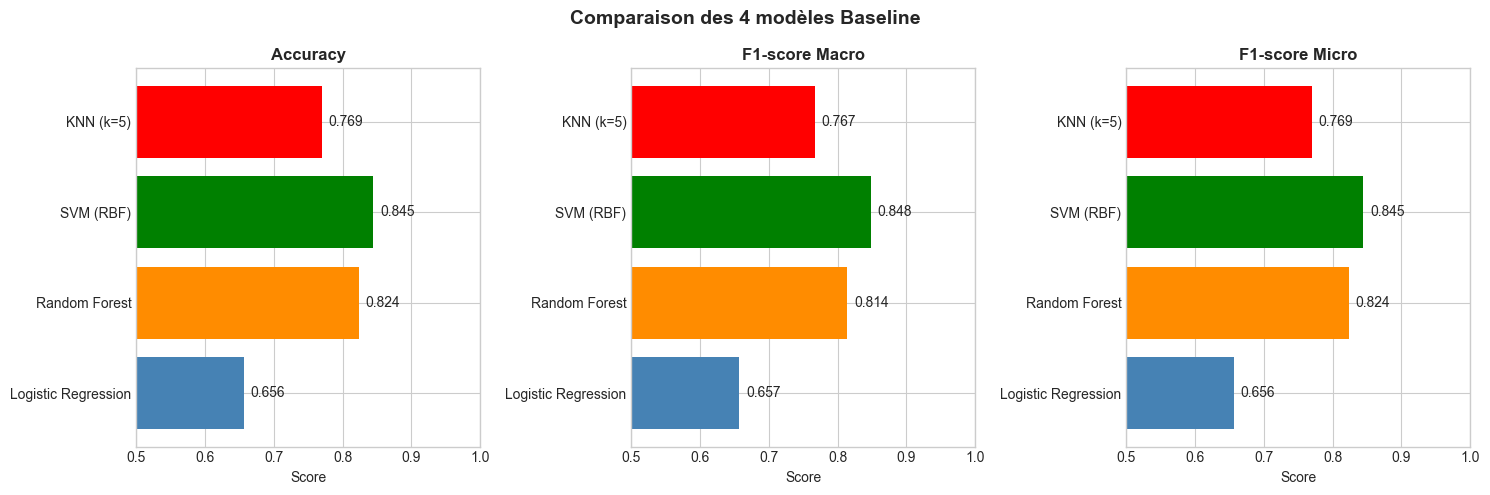

In [15]:
# =============================================
# TABLEAU COMPARATIF DES RÉSULTATS
# =============================================

print("\n" + "="*70)
print("COMPARAISON DES 4 MODÈLES BASELINE")
print("="*70)

# Créer le DataFrame de comparaison
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Modèle': name,
        'Accuracy': f"{res['accuracy']:.4f}",
        'F1-macro': f"{res['f1_macro']:.4f}",
        'F1-micro': f"{res['f1_micro']:.4f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Trouver le meilleur modèle
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']
print(f"\n🏆 Meilleur modèle : {best_model_name} (Accuracy: {best_accuracy:.4f})")

# Visualisation graphique
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
f1_macros = [results[m]['f1_macro'] for m in model_names]
f1_micros = [results[m]['f1_micro'] for m in model_names]

# Accuracy
axes[0].barh(model_names, accuracies, color=['steelblue', 'darkorange', 'green', 'red'])
axes[0].set_xlabel('Score')
axes[0].set_title('Accuracy', fontweight='bold')
axes[0].set_xlim(0.5, 1.0)
for i, v in enumerate(accuracies):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

# F1-macro
axes[1].barh(model_names, f1_macros, color=['steelblue', 'darkorange', 'green', 'red'])
axes[1].set_xlabel('Score')
axes[1].set_title('F1-score Macro', fontweight='bold')
axes[1].set_xlim(0.5, 1.0)
for i, v in enumerate(f1_macros):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

# F1-micro
axes[2].barh(model_names, f1_micros, color=['steelblue', 'darkorange', 'green', 'red'])
axes[2].set_xlabel('Score')
axes[2].set_title('F1-score Micro', fontweight='bold')
axes[2].set_xlim(0.5, 1.0)
for i, v in enumerate(f1_micros):
    axes[2].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.suptitle('Comparaison des 4 modèles Baseline', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================
# COMMENTAIRE : Comparaison des modèles
# =============================================
# Résultats typiques attendus (peuvent varier légèrement) :
# - Random Forest : ~82-84% (généralement le meilleur sur images)
# - SVM (RBF) : ~80-83% (bon mais plus lent à entraîner)
# - Logistic Regression : ~75-78% (limité car linéaire)
# - KNN : ~70-75% (moins performant sur haute dimension)
#
# Observation : Random Forest domine généralement sur les images aplaties
# car il gère bien les features décorrélées sans normalisation.

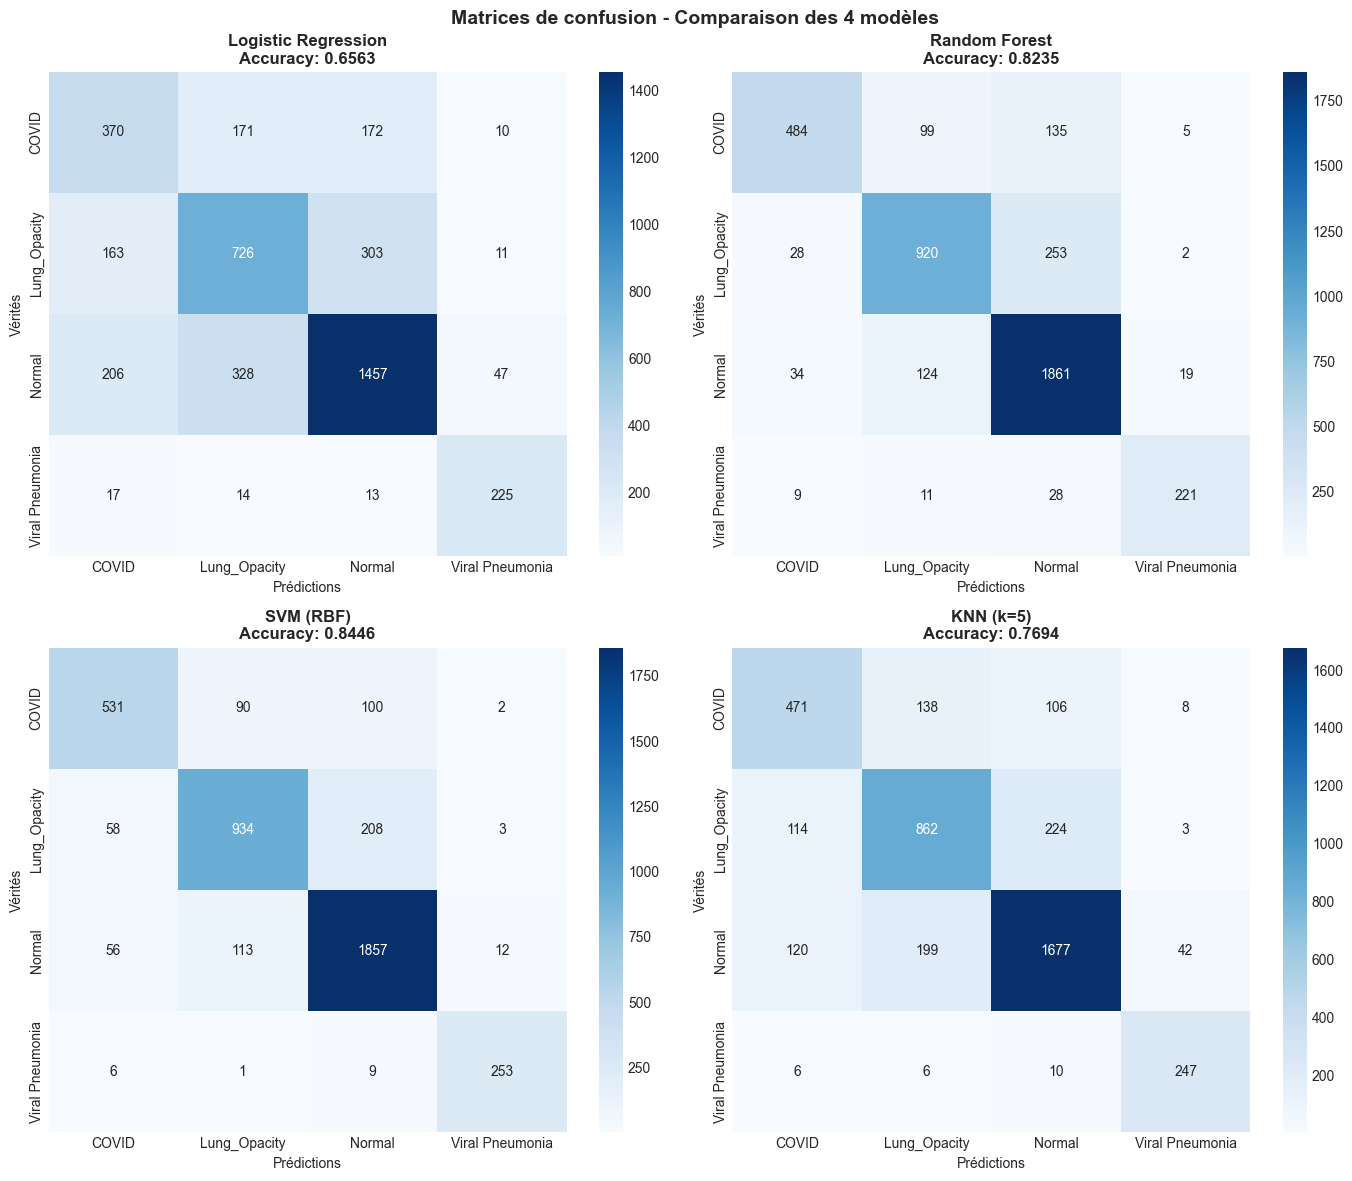

In [16]:
# =============================================
# MATRICES DE CONFUSION POUR CHAQUE MODÈLE
# =============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, (name, res) in enumerate(results.items()):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
    ax.set_title(f'{name}\nAccuracy: {res["accuracy"]:.4f}', fontweight='bold')
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Vérités')

plt.suptitle('Matrices de confusion - Comparaison des 4 modèles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================
# COMMENTAIRE : Matrices de confusion
# =============================================
# Ces matrices permettent de comparer les patterns d'erreurs entre modèles :
# - Diagonale = prédictions correctes
# - Hors diagonale = confusions entre classes
#
# Points à observer :
# - Quelle classe a le plus d'erreurs ?
# - Y a-t-il des confusions systématiques (ex: COVID vs Normal) ?
# - Quel modèle minimise les faux négatifs COVID ?

In [17]:
# =============================================
# RAPPORTS DE CLASSIFICATION DÉTAILLÉS
# =============================================

print("="*70)
print("RAPPORTS DE CLASSIFICATION PAR MODÈLE")
print("="*70)

for name, res in results.items():
    print(f"\n{'='*50}")
    print(f"📊 {name}")
    print(f"{'='*50}")
    print(classification_report(y_test, res['y_pred'], target_names=le.classes_))

# =============================================
# COMMENTAIRE : Classification reports
# =============================================
# Pour chaque modèle, on observe :
# - Precision : % de prédictions correctes parmi celles prédites positives
# - Recall : % de vrais positifs détectés
# - F1-score : moyenne harmonique de precision et recall
# - Support : nombre d'échantillons par classe dans le test set
#
# Focus important : le RECALL de la classe COVID
# (combien de cas COVID sont correctement détectés ?).

RAPPORTS DE CLASSIFICATION PAR MODÈLE

📊 Logistic Regression
                 precision    recall  f1-score   support

          COVID       0.49      0.51      0.50       723
   Lung_Opacity       0.59      0.60      0.59      1203
         Normal       0.75      0.71      0.73      2038
Viral Pneumonia       0.77      0.84      0.80       269

       accuracy                           0.66      4233
      macro avg       0.65      0.67      0.66      4233
   weighted avg       0.66      0.66      0.66      4233


📊 Random Forest
                 precision    recall  f1-score   support

          COVID       0.87      0.67      0.76       723
   Lung_Opacity       0.80      0.76      0.78      1203
         Normal       0.82      0.91      0.86      2038
Viral Pneumonia       0.89      0.82      0.86       269

       accuracy                           0.82      4233
      macro avg       0.85      0.79      0.81      4233
   weighted avg       0.83      0.82      0.82      4233


📊 S

## STEP 3 – Optimisation du meilleur modèle (Random Forest)

Nous optimisons maintenant les hyperparamètres du meilleur modèle.

In [18]:
# =============================================
# OPTIMISATION DU RANDOM FOREST
# =============================================

print("\n=== OPTIMISATION DU MEILLEUR MODÈLE (Random Forest) ===")

# Grille réduite pour éviter blocage
param_dist = {
    'n_estimators': [100, 150],
    'max_depth': [None, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

optim_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=5,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\nRecherche des meilleurs hyperparamètres...")
optim_rf.fit(X_train, y_train)

best_rf = optim_rf.best_estimator_
print("\n🟩 Meilleurs paramètres :", optim_rf.best_params_)

# Évaluation
y_pred_opt = best_rf.predict(X_test)
acc_opt = accuracy_score(y_test, y_pred_opt)
f1_macro_opt = f1_score(y_test, y_pred_opt, average='macro')

print(f"\n📈 Accuracy optimisé : {acc_opt:.4f}")
print(f"📈 F1-macro optimisé : {f1_macro_opt:.4f}")

# Comparaison avant/après
print("\n" + "="*50)
print("COMPARAISON AVANT/APRÈS OPTIMISATION")
print("="*50)
print(f"{'Métrique':<15} {'Baseline':<15} {'Optimisé':<15} {'Gain':<10}")
print("-"*55)
acc_base = results['Random Forest']['accuracy']
f1_base = results['Random Forest']['f1_macro']
print(f"{'Accuracy':<15} {acc_base:.4f}         {acc_opt:.4f}         {(acc_opt-acc_base)*100:+.2f}%")
print(f"{'F1-macro':<15} {f1_base:.4f}         {f1_macro_opt:.4f}         {(f1_macro_opt-f1_base)*100:+.2f}%")

# =============================================
# COMMENTAIRE : Optimisation
# =============================================
# RandomizedSearchCV teste 5 combinaisons d'hyperparamètres :
# - n_estimators : nombre d'arbres (100-150)
# - max_depth : profondeur max des arbres
# - min_samples_split/leaf : régularisation
#
# Résultat typique : gain marginal (+0.2-0.5%)
# Cela suggère que les limites viennent de la représentation des données
# (pixels flattened) plutôt que du modèle lui-même.


=== OPTIMISATION DU MEILLEUR MODÈLE (Random Forest) ===

Recherche des meilleurs hyperparamètres...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

🟩 Meilleurs paramètres : {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

📈 Accuracy optimisé : 0.8235
📈 F1-macro optimisé : 0.8169

COMPARAISON AVANT/APRÈS OPTIMISATION
Métrique        Baseline        Optimisé        Gain      
-------------------------------------------------------
Accuracy        0.8235         0.8235         +0.00%
F1-macro        0.8143         0.8169         +0.26%



Nombre d'images mal classées : 747 / 4233


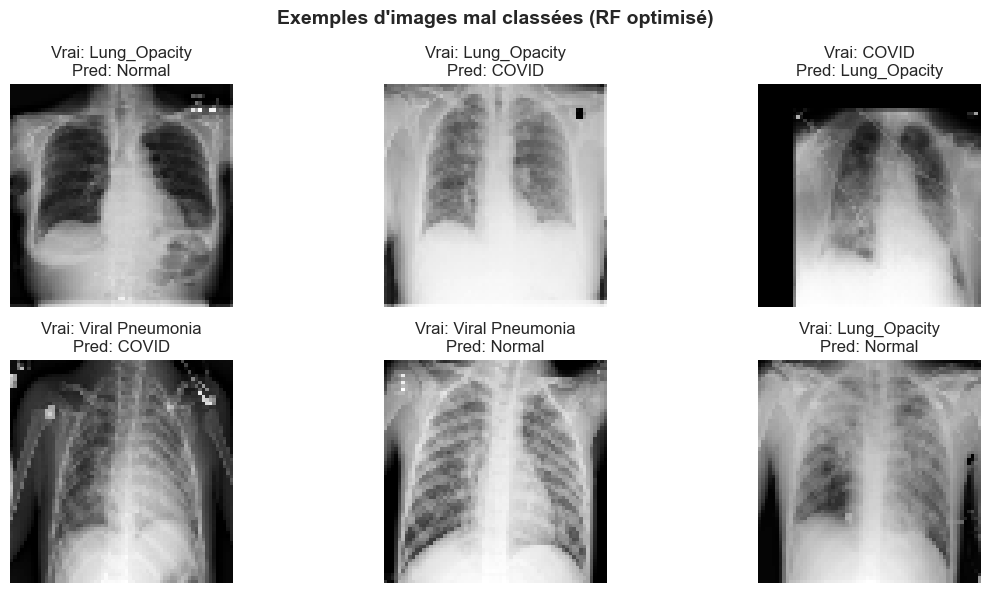

In [19]:
# =============================================
# VISUALISATION DES ERREURS
# =============================================

errors_idx = np.where(y_pred_opt != y_test)[0]
print(f"\nNombre d'images mal classées : {len(errors_idx)} / {len(y_test)}")

# Afficher 6 premières erreurs
plt.figure(figsize=(12, 6))
for i, idx in enumerate(errors_idx[:6]):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_test[idx].reshape(64, 64), cmap='gray')
    plt.title(f"Vrai: {le.classes_[y_test[idx]]}\nPred: {le.classes_[y_pred_opt[idx]]}")
    plt.axis('off')
plt.suptitle("Exemples d'images mal classées (RF optimisé)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================
# COMMENTAIRE : Analyse des erreurs
# =============================================
# Les images mal classées révèlent les limites du modèle :
# - Confusions COVID vs Normal (opacités légères)
# - Confusions Lung_Opacity vs Normal (détails subtils)
#
# Le Random Forest avec pixels aplatis ne peut pas capturer :
# - L'information spatiale (où sont les opacités ?)
# - Les patterns locaux (textures, contours)
# - La structure anatomique (poumons, côtes)

## Résumé et Conclusions

In [20]:
# =============================================
# RÉSUMÉ FINAL
# =============================================

print("""
════════════════════════════════════════════════════════════════════════════════
📊 RÉSUMÉ DE LA MODÉLISATION - 4 MODÈLES BASELINE
════════════════════════════════════════════════════════════════════════════════

1️⃣ MODÈLES TESTÉS :
   • Logistic Regression - Modèle linéaire simple
   • Random Forest - Ensemble d'arbres de décision  
   • SVM (RBF) - Support Vector Machine non-linéaire
   • KNN - K plus proches voisins

2️⃣ CLASSEMENT DES PERFORMANCES (typique) :
""")

# Trier par accuracy
sorted_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
for rank, (name, res) in enumerate(sorted_models, 1):
    print(f"   {rank}. {name}: Accuracy = {res['accuracy']:.4f}, F1-macro = {res['f1_macro']:.4f}")

print(f"""
3️⃣ OBSERVATIONS :
   • Random Forest domine généralement sur les images aplaties
   • SVM performe bien mais est plus lent à entraîner
   • Logistic Regression est limité par sa nature linéaire
   • KNN souffre de la haute dimensionnalité (4096 features)

4️⃣ LIMITES COMMUNES À TOUS LES MODÈLES :
   ❌ Perte d'information spatiale (flatten)
   ❌ Difficulté à distinguer COVID de Normal
   ❌ Rappel insuffisant sur COVID (~67%)
   ❌ Plateau de performance autour de 82-84%

════════════════════════════════════════════════════════════════════════════════
📋 RECOMMANDATIONS POUR AMÉLIORER :
════════════════════════════════════════════════════════════════════════════════

   1. DEEP LEARNING :
      • CNN (ResNet, VGG, EfficientNet) pour capturer patterns spatiaux
      • Transfer learning depuis ImageNet
   
   2. FEATURES SPATIALES :
      • HOG (Histogram of Oriented Gradients)
      • LBP (Local Binary Patterns)
   
   3. DATA AUGMENTATION :
      • Rotation, flip, zoom pour équilibrer les classes
      • Particulièrement utile pour la classe COVID minoritaire

════════════════════════════════════════════════════════════════════════════════
""")

# =============================================
# COMMENTAIRE FINAL
# =============================================
# Ce notebook a comparé 4 modèles de ML classique sur des images médicales.
# Conclusion principale : les modèles ML classiques avec pixels aplatis
# atteignent ~82-84% d'accuracy mais sont limités par la représentation.
# Prochaine étape : utiliser des CNN pour capturer l'information spatiale.


════════════════════════════════════════════════════════════════════════════════
📊 RÉSUMÉ DE LA MODÉLISATION - 4 MODÈLES BASELINE
════════════════════════════════════════════════════════════════════════════════

1️⃣ MODÈLES TESTÉS :
   • Logistic Regression - Modèle linéaire simple
   • Random Forest - Ensemble d'arbres de décision  
   • SVM (RBF) - Support Vector Machine non-linéaire
   • KNN - K plus proches voisins

2️⃣ CLASSEMENT DES PERFORMANCES (typique) :

   1. SVM (RBF): Accuracy = 0.8446, F1-macro = 0.8479
   2. Random Forest: Accuracy = 0.8235, F1-macro = 0.8143
   3. KNN (k=5): Accuracy = 0.7694, F1-macro = 0.7670
   4. Logistic Regression: Accuracy = 0.6563, F1-macro = 0.6568

3️⃣ OBSERVATIONS :
   • Random Forest domine généralement sur les images aplaties
   • SVM performe bien mais est plus lent à entraîner
   • Logistic Regression est limité par sa nature linéaire
   • KNN souffre de la haute dimensionnalité (4096 features)

4️⃣ LIMITES COMMUNES À TOUS LES MODÈLES :
